In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [2]:
# --- Metrics ---
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Read data

In [3]:
df = pd.read_csv("df_final_bh_amazonas.csv")

In [4]:
df.head()

,Date,DayOfWeek,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,IsDayAfterHoliday,temp_max,temp_min,temp_mean,humidity_max,humidity_min,NUMBER_INT,CO,MP10,O3,MP2.5,SO2
0,2015-01-01,Thu,3,1,1,0,1,0,33.9,20.6,25.912500,89.0,32.0,30,0.0,NaN,68.0,NaN,82.0
1,2015-01-02,Fri,4,1,1,0,0,1,32.9,21.0,26.050000,87.0,38.0,43,0.0,NaN,79.0,NaN,83.0
2,2015-01-03,Sat,5,1,1,1,0,0,33.5,20.2,26.683333,83.0,38.0,23,0.0,NaN,44.0,NaN,83.0
3,2015-01-04,Sun,6,1,1,1,0,0,30.6,22.2,25.641667,81.0,43.0,20,0.0,NaN,49.0,NaN,82.0
4,2015-01-05,Mon,0,2,1,0,0,0,30.8,20.8,25.520833,79.0,36.0,51,0.0,NaN,59.0,NaN,82.0


In [5]:
df.count()

Date                 1826
DayOfWeek            1826
DayOfWeekNum         1826
WeekOfYear           1826
Month                1826
IsWeekend            1826
IsHoliday            1826
IsDayAfterHoliday    1826
temp_max             1826
temp_min             1826
temp_mean            1826
humidity_max         1826
humidity_min         1826
NUMBER_INT           1826
CO                   1581
MP10                 1457
O3                   1265
MP2.5                1195
SO2                  1091
dtype: int64

### Set features

In [6]:
selected_cols_final = [
    'Date',
    'DayOfWeekNum',
    'WeekOfYear',
    'Month',
    'IsWeekend',
    'IsHoliday',
    'NUMBER_INT',
    'MP10',
    'temp_max',
    'temp_min',
    'humidity_max',
]

df_final = df[selected_cols_final].copy()

In [7]:
# add lag

df_final['MP10_lag1'] = df_final['MP10'].shift(1)
df_final['MP10_lag2'] = df_final['MP10'].shift(2)
df_final['MP10_lag3'] = df_final['MP10'].shift(3)

df_final['temp_min_lag1'] = df_final['temp_min'].shift(1)
df_final['temp_min_lag2'] = df_final['temp_min'].shift(2)
df_final['temp_min_lag3'] = df_final['temp_min'].shift(3)

# df_final['humidity_max_lag1'] = df_final['humidity_max'].shift(1)
# df_final['humidity_max_lag2'] = df_final['humidity_max'].shift(2)
# df_final['humidity_max_lag3'] = df_final['humidity_max'].shift(3)

In [8]:
df_final = df_final.dropna()

In [9]:
# Check non-null counts and data types
df_final.info()

# Check descriptive statistics
df_final.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 14 to 1825
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1300 non-null   object 
 1   DayOfWeekNum   1300 non-null   int64  
 2   WeekOfYear     1300 non-null   int64  
 3   Month          1300 non-null   int64  
 4   IsWeekend      1300 non-null   int64  
 5   IsHoliday      1300 non-null   int64  
 6   NUMBER_INT     1300 non-null   int64  
 7   MP10           1300 non-null   float64
 8   temp_max       1300 non-null   float64
 9   temp_min       1300 non-null   float64
 10  humidity_max   1300 non-null   float64
 11  MP10_lag1      1300 non-null   float64
 12  MP10_lag2      1300 non-null   float64
 13  MP10_lag3      1300 non-null   float64
 14  temp_min_lag1  1300 non-null   float64
 15  temp_min_lag2  1300 non-null   float64
 16  temp_min_lag3  1300 non-null   float64
dtypes: float64(10), int64(6), object(1)
memory usage: 182.8+

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,1300,1300,2019-12-31,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeekNum,1300.0,NaN,NaN,NaN,3.006154,2.004988,0.0,1.0,3.0,5.0,6.0
WeekOfYear,1300.0,NaN,NaN,NaN,26.920769,13.905732,1.0,15.0,27.0,38.0,53.0
Month,1300.0,NaN,NaN,NaN,6.584615,3.178509,1.0,4.0,7.0,9.0,12.0
IsWeekend,1300.0,NaN,NaN,NaN,0.287692,0.452861,0.0,0.0,0.0,1.0,1.0
IsHoliday,1300.0,NaN,NaN,NaN,0.021538,0.145227,0.0,0.0,0.0,0.0,1.0
NUMBER_INT,1300.0,NaN,NaN,NaN,48.214615,15.901814,11.0,36.0,47.0,59.0,94.0
MP10,1300.0,NaN,NaN,NaN,20.342308,10.17002,4.0,14.0,18.0,25.0,64.0
temp_max,1300.0,NaN,NaN,NaN,28.260462,3.042062,19.1,26.2,28.4,30.4,37.7
temp_min,1300.0,NaN,NaN,NaN,17.599154,2.7255,7.7,15.8,18.1,19.6,24.1


In [10]:
df_final.dtypes

Date              object
DayOfWeekNum       int64
WeekOfYear         int64
Month              int64
IsWeekend          int64
IsHoliday          int64
NUMBER_INT         int64
MP10             float64
temp_max         float64
temp_min         float64
humidity_max     float64
MP10_lag1        float64
MP10_lag2        float64
MP10_lag3        float64
temp_min_lag1    float64
temp_min_lag2    float64
temp_min_lag3    float64
dtype: object

## Train

In [11]:
df_final['Date'] = pd.to_datetime(df_final['Date'])
# df_final = df_final.sort_values(by='Date')

# remove the last 5 days (account for lag ...)
# df_final = df_final[:-5]

# Range for training and testing (4 years for training, 1 year for validation)
min_year = df_final['Date'].dt.year.min()
train_mask = df_final['Date'].dt.year < (min_year + 4)
val_mask = df_final['Date'].dt.year == (min_year + 4)



df_train = df_final[train_mask]
df_val = df_final[val_mask]

df_train = df_train.drop(columns=['Date'])
df_val = df_val.drop(columns=['Date'])

X = df_final.drop(columns=['Date', 'NUMBER_INT'])
y = df_final['NUMBER_INT']


X_train = df_train.drop(columns=['NUMBER_INT'])
y_train = df_train['NUMBER_INT']

X_val = df_val.drop(columns=['NUMBER_INT'])
y_val = df_val['NUMBER_INT']

In [12]:
df_train.head()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,MP10,temp_max,temp_min,humidity_max,MP10_lag1,MP10_lag2,MP10_lag3,temp_min_lag1,temp_min_lag2,temp_min_lag3
14,3,3,1,0,0,40,24.0,30.1,20.1,67.0,26.0,26.0,26.0,21.8,21.4,19.7
15,4,3,1,0,0,36,25.0,32.4,20.9,65.0,24.0,26.0,26.0,20.1,21.8,21.4
16,5,3,1,1,0,31,22.0,32.1,20.4,62.0,25.0,24.0,26.0,20.9,20.1,21.8
17,6,3,1,1,0,21,19.0,32.9,18.5,72.0,22.0,25.0,24.0,20.4,20.9,20.1
18,0,4,1,0,0,37,24.0,32.6,21.2,61.0,19.0,22.0,25.0,18.5,20.4,20.9


In [13]:
df_train.tail()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,MP10,temp_max,temp_min,humidity_max,MP10_lag1,MP10_lag2,MP10_lag3,temp_min_lag1,temp_min_lag2,temp_min_lag3
1444,5,50,12,1,0,40,13.0,32.0,21.4,66.0,16.0,20.0,11.0,19.9,18.8,19.5
1449,3,51,12,0,0,57,18.0,33.5,20.4,88.0,22.0,20.0,12.0,21.5,20.4,20.6
1450,4,51,12,0,0,55,22.0,32.0,21.0,87.0,18.0,22.0,20.0,20.4,21.5,20.4
1451,5,51,12,1,0,48,26.0,33.1,19.0,91.0,22.0,18.0,22.0,21.0,20.4,21.5
1452,6,51,12,1,0,49,18.0,32.6,17.9,92.0,26.0,22.0,18.0,19.0,21.0,20.4


In [14]:
df_val.head()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,MP10,temp_max,temp_min,humidity_max,MP10_lag1,MP10_lag2,MP10_lag3,temp_min_lag1,temp_min_lag2,temp_min_lag3
1464,4,1,1,0,0,37,18.0,25.4,19.0,91.0,20.0,14.0,10.0,20.4,18.9,19.2
1465,5,1,1,1,0,36,21.0,30.1,18.6,91.0,18.0,20.0,14.0,19.0,20.4,18.9
1466,6,1,1,1,0,30,14.0,31.8,18.8,90.0,21.0,18.0,20.0,18.6,19.0,20.4
1467,0,2,1,0,0,37,10.0,31.2,20.9,79.0,14.0,21.0,18.0,18.8,18.6,19.0
1468,1,2,1,0,0,39,12.0,29.6,19.7,87.0,10.0,14.0,21.0,20.9,18.8,18.6


In [15]:
df_val.tail()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,MP10,temp_max,temp_min,humidity_max,MP10_lag1,MP10_lag2,MP10_lag3,temp_min_lag1,temp_min_lag2,temp_min_lag3
1821,4,52,12,0,0,48,9.0,29.1,19.9,83.0,9.0,8.0,13.0,20.8,17.4,17.6
1822,5,52,12,1,0,39,10.0,28.6,19.7,88.0,9.0,9.0,8.0,19.9,20.8,17.4
1823,6,52,12,1,0,36,8.0,29.4,18.8,90.0,10.0,9.0,9.0,19.7,19.9,20.8
1824,0,1,12,0,0,41,8.0,29.3,18.1,84.0,8.0,10.0,9.0,18.8,19.7,19.9
1825,1,1,12,0,0,49,8.0,29.9,18.8,79.0,8.0,8.0,10.0,18.1,18.8,19.7


## Test (10x with cv)

In [16]:
results = []
results30 = []

param_grid = {
    'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160],
    'max_depth': [2, 4, 6, 10, 12, 14, 16, 18, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [17]:
for i in range(10):
    grid_search = GridSearchCV(
        estimator=XGBRegressor(random_state=i),
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print(f"\nRun {i+1} Best Hyperparameters:")
    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Best R-squared: {grid_search.best_score_:.4f}")

    best_xgb_model = grid_search.best_estimator_
    y_pred = best_xgb_model.predict(X_val)

    # Metrics 1y
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    mape_val = mape(y_val, y_pred)
    smape_val = smape(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    corr = np.corrcoef(y_val, y_pred)[0, 1]

    # Metrics 30d
    y_pred_30d = best_xgb_model.predict(X_val[:30])
    y_val_30 = y_val[:30]
    mse_30d = mean_squared_error(y_val_30, y_pred_30d)
    rmse_30d = np.sqrt(mse_30d)
    mae_30d = mean_absolute_error(y_val_30, y_pred_30d)
    mape_val_30d = mape(y_val_30, y_pred_30d)
    smape_val_30d = smape(y_val_30, y_pred_30d)
    r2_30d = r2_score(y_val_30, y_pred_30d)
    corr_30d = np.corrcoef(y_val_30, y_pred_30d)[0, 1]

    results.append({
        'run': i+1,
        'random_state': i,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape_val,
        'sMAPE': smape_val,
        'R2': r2,
        'Correlation': corr,
        'Best Params': grid_search.best_params_,
        'Best Cross-validated R-squared': grid_search.best_score_
    })

    results30.append({
        'run': i+1,
        'random_state': i,
        'MSE_30d': mse_30d,
        'RMSE_30d': rmse_30d,
        'MAE_30d': mae_30d,
        'MAPE_30d': mape_val_30d,
        'sMAPE_30d': smape_val_30d,
        'R2_30d': r2_30d,
        'Correlation_30d': corr_30d
    })




Run 1 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 0.8}
Best R-squared: 0.5574

Run 2 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 0.9}
Best R-squared: 0.5609

Run 3 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 0.9}
Best R-squared: 0.5570

Run 4 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 0.9}
Best R-squared: 0.5571

Run 5 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 0.9}
Best R-squared: 0.5584

Run 6 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_es

### Results 1y

In [18]:
results_df = pd.DataFrame(results)
results_df

,run,random_state,MSE,RMSE,MAE,MAPE,sMAPE,R2,Correlation,Best Params,Best Cross-validated R-squared
0,1,0,135.590134,11.644318,8.838672,16.664762,18.072813,0.443546,0.780164,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.557373
1,2,1,135.046997,11.620972,8.837627,16.663399,18.073485,0.445775,0.782511,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.560872
2,3,2,137.906693,11.743368,8.912495,16.745653,18.208400,0.434039,0.780867,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.556992
3,4,3,137.342789,11.719334,8.933329,16.869332,18.307377,0.436353,0.778854,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.557129
4,5,4,134.923096,11.615640,8.836367,16.690232,18.066542,0.446284,0.781259,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.558363
5,6,5,135.518112,11.641225,8.826698,16.640072,18.014178,0.443842,0.780628,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.556337
6,7,6,134.643570,11.603602,8.816755,16.564847,17.939115,0.447431,0.783199,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.558740
7,8,7,139.826599,11.824830,8.908542,16.822103,18.336558,0.426160,0.770457,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.559398
8,9,8,135.518112,11.641225,8.826698,16.640072,18.014178,0.443842,0.780628,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.556337
9,10,9,135.518112,11.641225,8.826698,16.640072,18.014178,0.443842,0.780628,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.556337


In [19]:
results_df.describe()

,run,random_state,MSE,RMSE,MAE,MAPE,sMAPE,R2,Correlation,Best Cross-validated R-squared
count,10.00000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,4.50000,136.183421,11.669574,8.856388,16.694054,18.104682,0.441111,0.779919,0.557788
std,3.02765,3.02765,1.650504,0.070473,0.043550,0.092514,0.133765,0.006774,0.003534,0.001524
min,1.00000,0.00000,134.643570,11.603602,8.816755,16.564847,17.939115,0.426160,0.770457,0.556337
25%,3.25000,2.25000,135.164776,11.626035,8.826698,16.640072,18.014178,0.438151,0.780280,0.556501
50%,5.50000,4.50000,135.518112,11.641225,8.836997,16.664080,18.069678,0.443842,0.780628,0.557251
75%,7.75000,6.75000,136.904625,11.700580,8.891074,16.731797,18.174671,0.445292,0.781161,0.558646
max,10.00000,9.00000,139.826599,11.824830,8.933329,16.869332,18.336558,0.447431,0.783199,0.560872


### results 30d

In [20]:
results_df_30 = pd.DataFrame(results30)
results_df_30

,run,random_state,MSE_30d,RMSE_30d,MAE_30d,MAPE_30d,sMAPE_30d,R2_30d,Correlation_30d
0,1,0,120.027412,10.955702,8.256406,19.221589,22.388727,-0.329305,0.549476
1,2,1,122.759918,11.079707,8.404749,19.776552,23.051597,-0.359568,0.527859
2,3,2,128.155045,11.320558,8.527961,19.850138,23.298474,-0.419319,0.515478
3,4,3,124.469940,11.156610,8.528550,20.132629,23.488442,-0.378507,0.525349
4,5,4,125.048576,11.182512,8.505565,20.081519,23.289837,-0.384915,0.497982
5,6,5,119.810844,10.945814,8.365958,19.702957,22.895610,-0.326907,0.543858
6,7,6,121.672394,11.030521,8.350103,19.574889,22.736375,-0.347524,0.522967
7,8,7,134.264694,11.587264,8.784894,20.634472,24.165627,-0.486984,0.448937
8,9,8,119.810844,10.945814,8.365958,19.702957,22.895610,-0.326907,0.543858
9,10,9,119.810844,10.945814,8.365958,19.702957,22.895610,-0.326907,0.543858


In [21]:
results_df_30.describe()

,run,random_state,MSE_30d,RMSE_30d,MAE_30d,MAPE_30d,sMAPE_30d,R2_30d,Correlation_30d
count,10.00000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,4.50000,123.583051,11.115032,8.445610,19.838066,23.110591,-0.368684,0.521962
std,3.02765,3.02765,4.685608,0.208488,0.148321,0.378344,0.486091,0.051893,0.030170
min,1.00000,0.00000,119.810844,10.945814,8.256406,19.221589,22.388727,-0.486984,0.448937
25%,3.25000,2.25000,119.864986,10.948286,8.365958,19.702957,22.895610,-0.383313,0.517351
50%,5.50000,4.50000,122.216156,11.055114,8.385354,19.739755,22.973604,-0.353546,0.526604
75%,7.75000,6.75000,124.903917,11.176036,8.522362,20.023673,23.296315,-0.327507,0.543858
max,10.00000,9.00000,134.264694,11.587264,8.784894,20.634472,24.165627,-0.326907,0.549476


## Plots    

In [22]:
best_idx = results_df['RMSE'].idxmin()
print(f"Best run based on RMSE: Run {results_df.loc[best_idx, 'run']} with RMSE = {results_df.loc[best_idx, 'RMSE']:.2f}")

best_params = results_df.loc[best_idx, 'Best Params']
print(f"Best parameters: {best_params}")

best_random_state = results_df.loc[best_idx, 'run'] - 1 

# Rebuild the best model
best_model = XGBRegressor(random_state=best_random_state, **best_params)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_val)


Best run based on RMSE: Run 7 with RMSE = 11.60
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 0.9}


### 1y

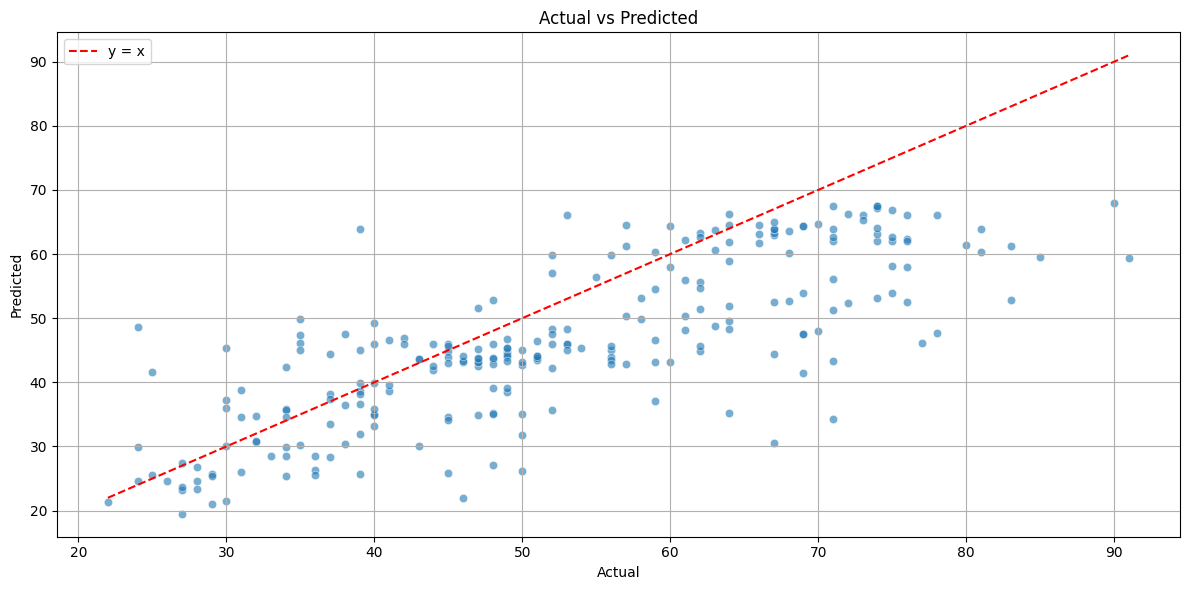

In [23]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val[:], y=y_pred_best, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

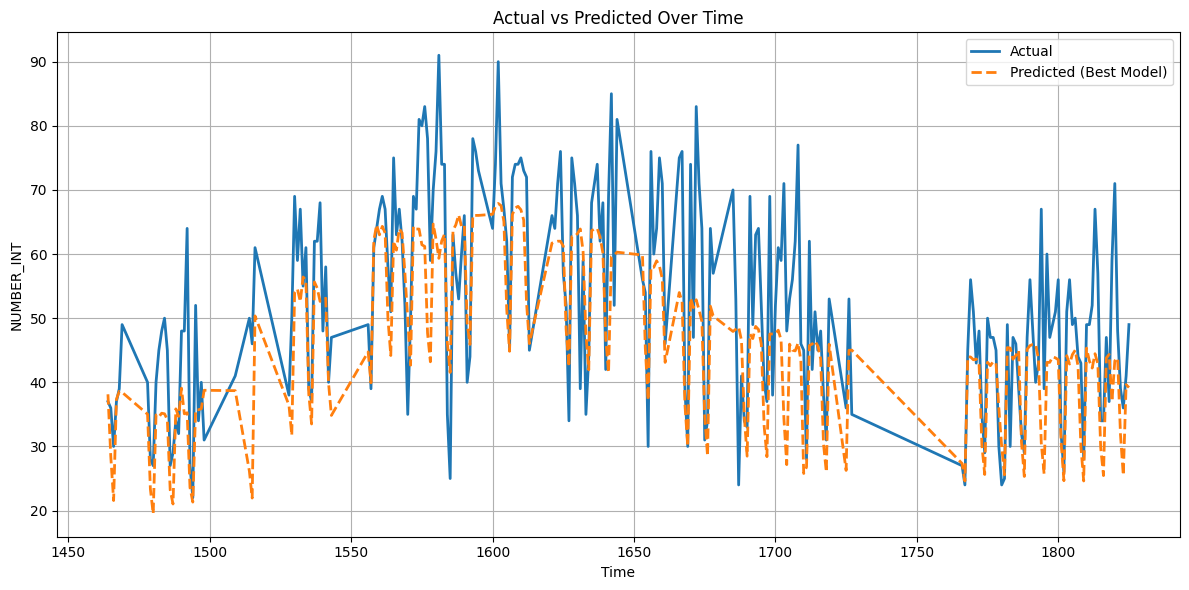

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val.values, label='Actual', linewidth=2)
plt.plot(y_val.index, y_pred_best, label='Predicted (Best Model)', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title(f'Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 30d

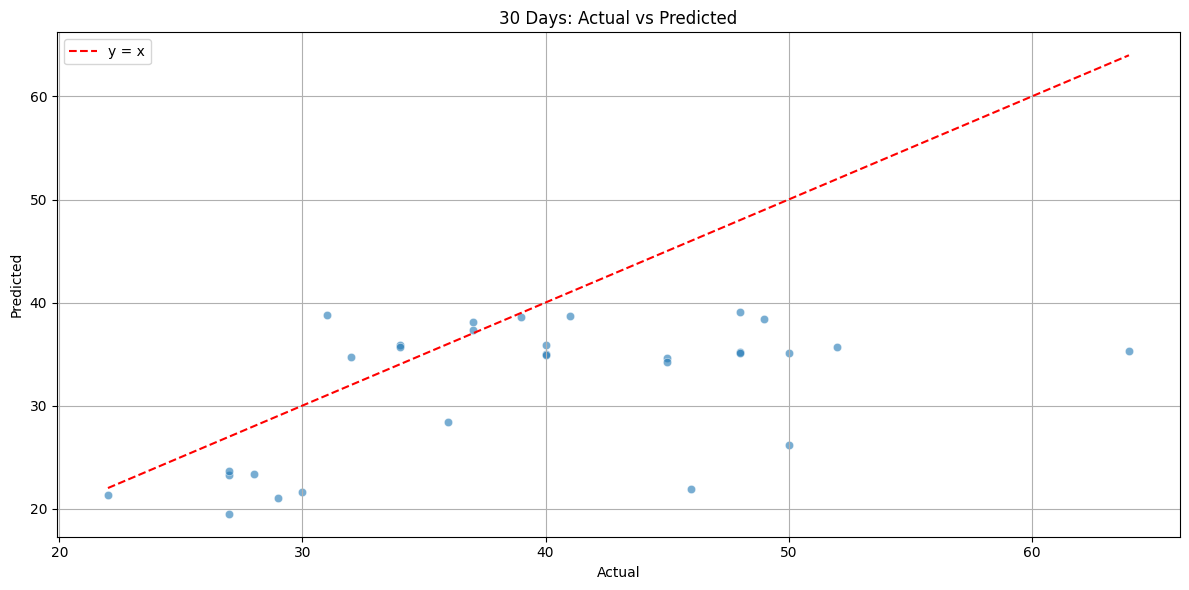

In [25]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val[:30], y=y_pred_best[:30], alpha=0.6)
plt.plot([y_val[:30].min(), y_val[:30].max()], [y_val[:30].min(), y_val[:30].max()], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('30 Days: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


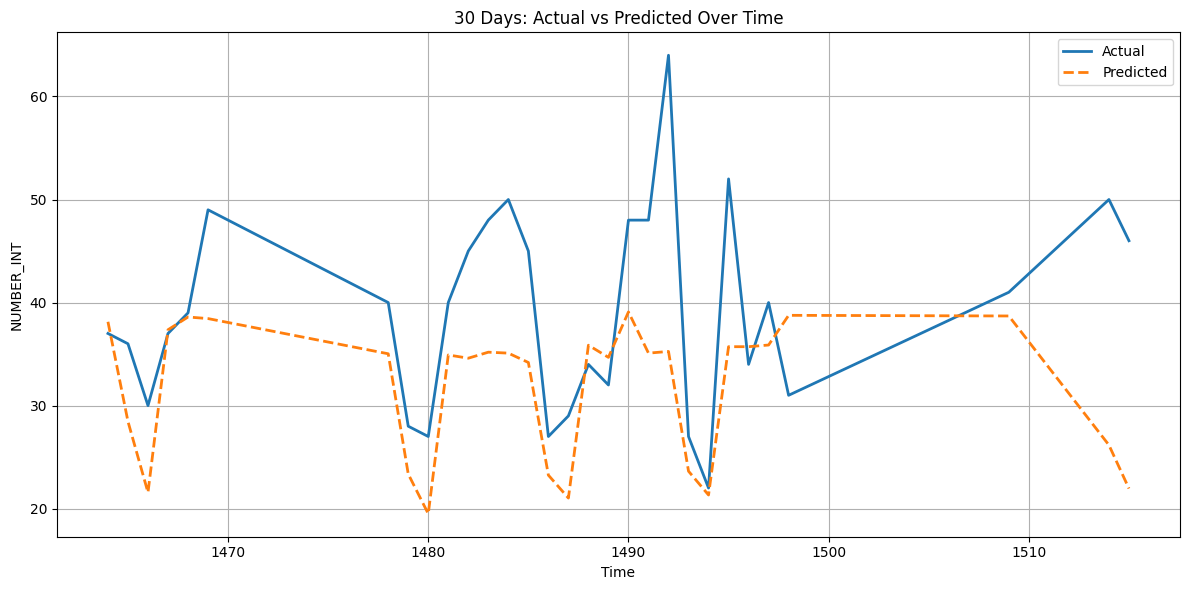

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index[:30], y_val[:30].values, label='Actual', linewidth=2)
plt.plot(y_val.index[:30], y_pred_best[:30], label='Predicted', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title('30 Days: Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

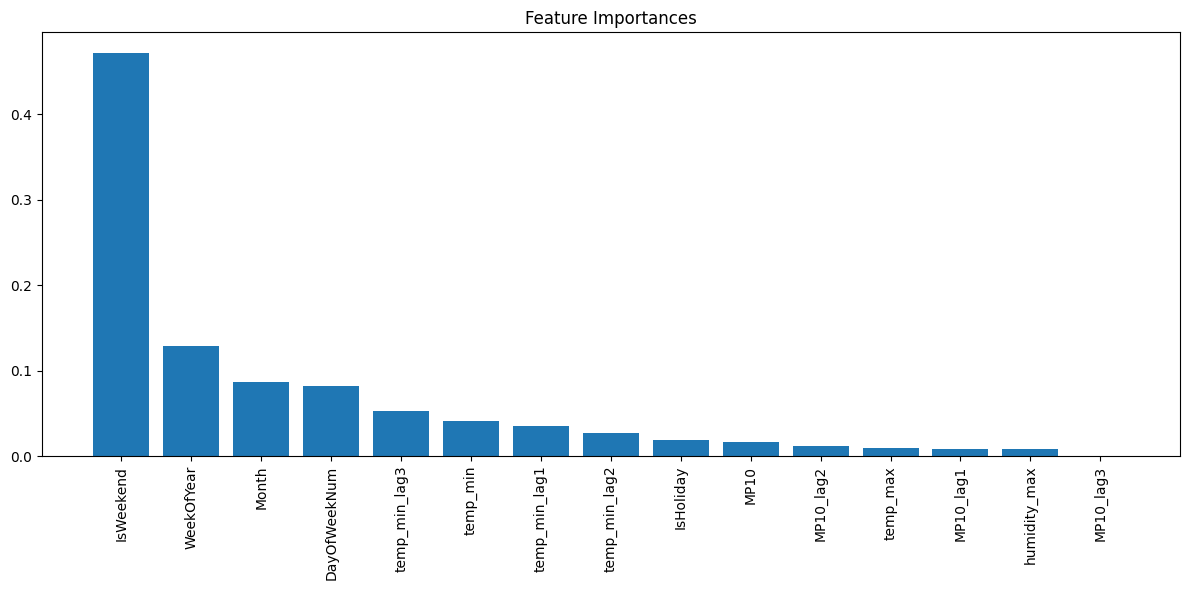

In [27]:
importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()